*HAMMOUTI Douae*

The second part of this notebook is based on EPFL and Stanford NLP materials

## TF-IDF

TF-IDF is a statistical method commonly used in Information Retrieval and Natural Language Processing.

It’s an important concept for understanding how search engines analyze web content and identify key terms that can be associated with search queries. Even with modern neural models, tf-idf and Okapi BM25 (an evolution of tf-idf) can be used to preliminarily filter the data. In a re-ranking scenario we'll first use tf-idf-like techniques - instead of heavier NNs - to retrieve a set of potentially relevant documents, then we'll refine our predictions with ad-hoc neural models.

Term frequency-inverse document frequency (TF-IDF) measures the importance of a word to a specific document and it’s the product of two statistics: term frequency (TF) and inverse document frequency (IDF). Let's compute tf-idf vectors on a small example

We will use a dataset of Python questions and answers from Stackoverflow. The dataset contains all the questions (around 700,000) asked between August 2, 2008 and Ocotober 19, 2016. For our purposes we will use only the Python questions, looking at `title` and `body` attributes.

In [1]:
## In order to use the Colab environment with external data allow Google to access your drive folder:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import re

#df_questions = pd.read_csv('drive/MyDrive/data/Questions.csv', delimiter=',', encoding='ISO-8859-1')
df_questions = pd.read_csv('./data/Questions.csv', delimiter=',', encoding='ISO-8859-1')
df_questions.head()

KeyboardInterrupt: 

In [3]:
len(df_questions)

607282

Having >600k documents, in this exercise we will limit the size of the dataset to 4000 for computational reasons.

In [4]:
df = df_questions.sample(4000, random_state=42)
len(df)

4000

Let's take a look at the dataset

In [5]:
sample = df.iloc[96]
print('title: {}, \nbody: {}'.format(sample['Title'],sample['Body']))

title: How to add all the elements inside loop in Python?, 
body: <p>For some reason I want this:</p>

<pre><code>a = ['ok.py', 'hello.py']
</code></pre>

<p>I want to calculate size of each elements and add all those sizes and store in a single variable:</p>

<pre><code>for i in a:
        dest = '/home/zurelsoft/my_files'
        fullname = os.path.join(dest, i) #Get the file_full_size to calculate size
        st = int(os.path.getsize(fullname))
        f_size = size(st)
</code></pre>

<p>It does this for every element. How can I add them all?</p>



Preprocessing is one of the major steps when we are dealing with any kind of text models. As you can see above, the body of the question has plently of html tags and special characters. Therefore, we need to get rid of them as much as we can. We need to clean to questions by removing html tags, special characters and digits.

In [6]:
def preprocess(title:str, body:str=None):
    '''
    args:
        title: string representing the question title
        body: string representing the question body
    output:
        text: a preprocessed concatenation of title and body
    '''

    # Your code here
    # given the title and (optional) the body of the question
    # 1. concatenate the two string
    # 2. perform lowercasing, remove tags as well as special characters and digits
    # Hint: match tags and non-word characters with regular expressions
    text = title if body is None else title + ' ' + body
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)  # remove tags
    text = re.sub(r'\W+', ' ', text)    # remove special characters
    text = re.sub(r'\d+', ' ', text)     # remove digits
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    text = text.strip()                   # remove leading/trailing spaces    

    return text

# Apply the function to the Title and Body columns, returning a list of string
# it could take a while to run
data = [preprocess(title, body) for title, body in zip(df['Title'], df['Body'])]

idx=100
print(df.iloc[idx]['Title'] + df.iloc[idx]['Body'])
print('-----------------------------------------------')
print(data[idx])

assert(data[idx][:115]=='google app engine how to use the task queue for this processing i m using the python gae sdk i have some processing')

Google App Engine: How to use the task queue for this processing?<p>I'm using the Python GAE SDK. </p>

<p>I have some processing that needs to be done on 6000+ instances of <code>MyKind</code>. It is too slow to be done in a single request, so I'm using the task queue. If I make a single task process only one entity, then it should take only a few seconds.</p>

<p>The <a href="http://code.google.com/appengine/docs/python/taskqueue/overview.html#Quotas_and_Limits" rel="nofollow">documentation</a> says that only 100 tasks can be added in a "batch". (What do they mean by that? In one request? In one task?)</p>

<p>So, assuming that "batch" means "request", I'm trying to figure out what the best way is to create a task for each entity in the datastore. What do you think?</p>

<p>It's easier if I can assume that the order of <code>MyKind</code> will never change. (The processing will never actually change the <code>MyKind</code> instances - it only creates new instances of other types.) I 

Before computing the frequencies we need to extract the words from the string of text, as well as performing some additional pre-processing such as stop words removal.

In [7]:
def tokenize(text: str) -> list[str]:
    # Your code here
    # perform tokenization and stopwords removal
    stopwords = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
        'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
        'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
        'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
        'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
        'and',  'but','if','or','because','as','until','while','of','at','by','for','with','about','against',
        'between','into','through','during','before','after','above','below','to','from','up','down','in',
        'out','on','off','over','under','again','further','then','once','here','there','when',
        'where','why','how','all','any','both','each','few','more','most','other',
        'some','such','no','nor','not',"don't",'only',
        'own','same',"shan't",'so',"it's",'s',"let's",'t',"that's",'ll',
        'm',"i'm",'ve',"you've",'d',"you'd",'re',"they're",
        'yourselves'
    ])
    tokens = text.split()
    tokens = [token for token in tokens if token not in stopwords]
    return tokens   


assert(tokenize(data[100])[:10] == ['google', 'app', 'engine', 'use', 'task', 'queue', 'processing', 'using', 'python', 'gae'])

Now apply this function to each document

In [8]:
# Your code here
# produce a list of lists named 'docs' by applying your function to each document
docs = [tokenize(doc) for doc in data]  
print(docs[100][:10])
assert(docs[100][:10] == ['google', 'app', 'engine', 'use', 'task', 'queue', 'processing', 'using', 'python', 'gae'])


['google', 'app', 'engine', 'use', 'task', 'queue', 'processing', 'using', 'python', 'gae']


In [9]:
sum([len(x) for x in docs])/len(docs)

126.17275

The average number of tokens per document should be around 123

And now create the vocabulary (set of unique words)

In [10]:
# Your code here
# create a set 'vocab' containing every word from every document
vocab = set()
for doc in docs:
    vocab.update(doc)   


len(vocab)

33851

You should get >33k words

We could think of tf-idf as a refinement of a much simpler bag-of-words model in which we simply count word occurrences (disregarding word order).
Indeed the first step is to convert the document collection into a matrix of token counts

In [11]:
# Create a matrix with shape (num of words, num of documents) counting word occurencies
# that is: count how many times a specific word (row) appears in a document (column)
# Return a pandas dataframe named 'df_count'
# It could take a while (~2 minutes), but you can monitor the progress with 'tqdm', try it!

import pandas as pd
from tqdm import tqdm

vocab_list = sorted(vocab)

rows = {}
for word in tqdm(vocab_list):
    rows[word] = []
    for doc in docs:
        rows[word].append(doc.count(word))

df_count = pd.DataFrame(rows).T  

print(df_count.shape)
df_count.head()


100%|██████████| 33851/33851 [03:14<00:00, 174.13it/s]


(33851, 4000)


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
_,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
__,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
___,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
____,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
______,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


How sparse is this matrix?

In [12]:
# Your code here
# compute the % of zeros in this matrix
num_zeros = (df_count == 0).sum().sum()
total_elements = df_count.size
sparsity = num_zeros / total_elements
print(sparsity)    

0.9981482895630853


The result should be >99%

**Why it happens?**

High sparsity is normal in text data and is one reason why sparse matrix formats and TF-IDF weighting are commonly used in NLP — they handle these mostly-zero matrices efficiently and give more meaningful features.

In practice, when building our vocabulary, we could ignore rare words and terms that appear in too many documents, in this case we will remove words that apper in less than 2 documents and in more than 95% of documents

In [13]:
min_df = 2
max_df = int(0.95*len(docs))
print('Min threshold {}\tMax threshold {}'.format(min_df, max_df))

Min threshold 2	Max threshold 3800


In [14]:
# Your code here
# iterate over the words (rows) and count how many documents the term appears in
# then apply our thresholds
# add the words to remove in the 'to_remove' set
# Hint: count non-zeros values
to_remove = set()
for word in df_count.index:
    doc_count = (df_count.loc[word] > 0).sum()
    if doc_count < min_df or doc_count > max_df:
        to_remove.add(word) 


print(len(to_remove))

23600


We should remove around 23k words, now let's apply the filter

In [15]:
# Your code here
# filter the vocab set by removing the words in 'to_remove'
vocab = vocab - to_remove  # remove rare and too frequent words
print(len(vocab))


10251


In [16]:
# Your code here
# remove the words also from the 'df_count' table
# Hint: keep in mind that words make up the index of the dataframe, therefore it should be easy to remove the unnecessary ones
df_count = df_count.drop(index=to_remove)   

            

df_count.shape

(10251, 4000)

Now we can compute the first term of tf-idf, that is tf or the term frequency:

$$
tf(t,d)=\frac{count(t, d)}{\sum_{t'}{count(t', d)}}
$$

where $t$ and $d$ are terms and documents, respectively, $count(t,d)$ is the number of times that $t$ occurs in $d$ and the denominator is the the number of terms in the document $d$

In [17]:
def tf(df_count, docs):
    df_tf = df_count.copy()

    # Your code here
    # starting from the raw counts compute the frequency and return the 'df_tf' dataframe
    # Hint: iterate over the columns (documents)

    col_sums = df_count.sum(axis=0)
    df_tf = df_count / col_sums
    df_tf = df_tf.fillna(0)

    return df_tf

# Apply the function
df_tf = tf(df_count, docs)

# Check first 5 rows and 5 columns
df_tf.iloc[:5, :5]


df_tf = tf(df_count, docs)
df_tf.head()
       


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
_,0.0,0.0,0.0,0.0,0.0,0.0,0.013333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
__,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
___,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
_________________________________________________________,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
__add__,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's see more in detail the tf score for the word 'lists' by filtering out zero values

In [18]:
nn = df_tf.loc['lists'].to_numpy()
nn[nn.nonzero()]

array([0.01428571, 0.01449275, 0.00564972, 0.00990099, 0.01136364,
       0.00917431, 0.00689655, 0.01351351, 0.0212766 , 0.00909091,
       0.04878049, 0.00223714, 0.02      , 0.01265823, 0.00625   ,
       0.04464286, 0.02325581, 0.04225352, 0.0106383 , 0.08333333,
       0.00510204, 0.01052632, 0.03225806, 0.03488372, 0.02272727,
       0.02040816, 0.01234568, 0.01282051, 0.01351351, 0.03846154,
       0.02777778, 0.02173913, 0.00892857, 0.01785714, 0.02339181,
       0.01020408, 0.03401361, 0.03030303, 0.03846154, 0.025     ,
       0.13636364, 0.01869159, 0.0625    , 0.01190476, 0.02380952,
       0.02222222, 0.01388889, 0.0060241 , 0.03614458, 0.04      ,
       0.00353357, 0.01041667, 0.02222222, 0.00840336, 0.02409639,
       0.00625   , 0.05      , 0.01515152, 0.0026178 , 0.07272727,
       0.01190476, 0.0075188 , 0.00854701, 0.01481481, 0.03571429,
       0.00462963, 0.02531646, 0.05555556, 0.00892857, 0.00518135,
       0.01315789, 0.03333333, 0.01351351, 0.04545455, 0.00198

And now compute the idf score as:
$$
idf(t, D) = log\frac{1+N}{1+|\{d:t \in d\}|}
$$
with $D$ is the collection of documents, $N=|D|$ and $|\{d:t \in d\}|$ is the number of documents in which $t$ appears. (log base 10)

In [ ]:
def idf(df_count):
    df_idf = {}  # dictionary {word: score}
    N = df_count.shape[1]  # number of documents

    # Your code here
    # iterate over the rows (words) and compute the idf score
    # return dataframe with the result and shape (num words, 1)

    for word in df_count.index:
        doc_count = (df_count.loc[word] > 0).sum()  # number of docs where word appears
        idf_score = np.log10((1 + N) / (1 + doc_count))  # add 1 to avoid division by zero
        df_idf[word] = idf_score

    df_idf = pd.DataFrame.from_dict(df_idf, orient='index', columns=['idf'])
    return df_idf

df_idf = idf(df_count)
df_idf.head()


,idf
_,1.459154
__,2.522987
___,3.125047
_________________________________________________________,3.125047
__add__,3.000109


In [20]:
df_idf.loc['lists']

idf    1.462289
Name: lists, dtype: float64

The idf score for the word 'list' should be ~1.87

Finally, we can now compute the tf-idf score by multipying the two factors

In [21]:
tf = df_tf.values
idf = df_idf.values

tf_idf = tf*idf
tf_idf = tf_idf.T
tf_idf.shape

(4000, 10251)

Let's see some examples from the first 10 documents:

In [22]:
for i in range(10):
    print(tf_idf[i])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.01945538 0.         0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Obviously the majority of values are zero, to get some interesting results we should filtering out zero values

In [ ]:
for i in range(10):
    # Your code here
    # print only non-zero values for the column 'i'
    nn = tf_idf[i]
    print(nn[nn.nonzero()])

[0.01249322 0.01462783 0.01676433 0.01541925 0.03114346 0.01393087
 0.02076483 0.02134705 0.01692014 0.00626788 0.00245804 0.01156459
 0.08872517 0.02459926 0.01034021 0.00398696 0.01233742 0.01947004
 0.03765847 0.02076483 0.00870491 0.01070618 0.01647383 0.00912089
 0.00805635 0.01849671 0.01295857 0.0159618  0.00574011 0.00682156
 0.0094728  0.01855138 0.02134705 0.01552064 0.01552064 0.01455088
 0.01829577 0.02027258 0.01643925 0.01109373 0.01513309 0.02459926
 0.01089408 0.01633792 0.02205962 0.02297829 0.01552064 0.01984617
 0.01855138 0.00548562 0.01352015 0.02239687 0.02134705 0.02278223
 0.01532099 0.00973099 0.01274218 0.16084802 0.02297829 0.01352015
 0.02297829 0.01984617 0.01513309 0.02027258 0.00139368 0.01222536
 0.02297829 0.01412447 0.0092915  0.00772587 0.00771691 0.02134705
 0.00647929 0.01692014 0.01725659 0.00950396 0.02297829 0.01913359
 0.02682272 0.01805912 0.01947004 0.01237567 0.02134705 0.02297829
 0.01016221 0.00659048 0.01174888 0.01393087 0.01222524 0.0115

Now that we have the tf-idf matrix we can compute the similarity between documents using the cosine similarity, that is the angle between the two vectors:

$$
cos(\theta) = \frac{A \cdot B}{\|A\| \|B\|}
$$

In [24]:
from numpy.linalg import norm

a=tf_idf[0]
b=tf_idf[1]

# Your code here
# compute the cosine similarity between a and b
cos_sim = np.dot(a, b) / (norm(a) * norm(b))
print(cos_sim)
# Hint: use the 'norm' function from numpy.linalg

0.006643629844401407


The similarity should be ~0.012

Now that we have learned how tf-idf works we can use the more efficient and complete scikit-learn's implementation.

We will use the [TfidfVectorizer](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for computing the tf-idf matrix and [cosine_similarity](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) for the similarity score. Look at the documentation for more info.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(analyzer='word', lowercase=False, stop_words='english',
                                   use_idf=True, smooth_idf=True, max_df=0.95, min_df=2)

tf_idf = tfidf_vectorizer.fit_transform(data) # train the model and apply it, it's equivalent to fit() followed by transform()
cosine_similarity(tf_idf[0], tf_idf[1])


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\douae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


array([[0.01191613]])

The similarity of the first two documents should be similar to the one computed with your implementation

But now let's move to the entire dataset to build something more useful and interesting

In [27]:
from tqdm import tqdm

data = []
# Your code here

# apply your preprocess() function to the original dataset (df_questions) and override 'data'
# it could take a while to run
for title, body in tqdm(zip(df_questions['Title'], df_questions['Body']), total=len(df_questions)):
    data.append(preprocess(title, body))        

def idf(df_count):
    df_idf = {}  # dictionary {word: score}
    N = df_count.shape[1]  # number of documents    

    for word in df_count.index:
        df = (df_count.loc[word] > 0).sum()
        if df > 0:
            idf_score = np.log(N / df)
        else:
            idf_score = 0
        df_idf[word] = idf_score
    df_idf = pd.DataFrame.from_dict(df_idf, orient='index', columns=['idf'])
    return df_idf


100%|██████████| 607282/607282 [01:15<00:00, 8025.15it/s]


And train the model

In [28]:
tfidf_vectorizer = TfidfVectorizer(decode_error='replace', strip_accents='unicode', analyzer='word',
                       stop_words='english', norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True,
                       max_df=0.95, min_df=2, max_features=1000)

tf_idf = tfidf_vectorizer.fit_transform(data)
tf_idf.shape

(607282, 1000)

We limited the vocabulary to 1000 features (i.e., top 1000 most frequent words), that's why the shape of the term-document matrix is (607282, 1000)

Please notice that we have asked to perform a L2 normalization this time and keep in mind that the cosine similarity between two normalized vectors is simply their dot product; therefore with this new normalized matrix it is sufficient to compute the dot product to get the cosine similarity. Don't forget this detail!

Finally, to better deal with a large amount of data and compute similarity more efficiently, we will rely on the faiss library.

Developed by Meta, it applies approximation techniques and GPU acceleration. If you want to learn more you can check the official documentation at [https://faiss.ai](https://faiss.ai/) or this guide [(https://www.pinecone.io/learn/series/faiss)](https://www.pinecone.io/learn/series/faiss/)

In [30]:
# Install faiss-cpu or faiss-gpu depending on GPU availability of your machine:
#!pip install faiss-cpu
# or
#!pip install faiss-gpu-cu12

import faiss

matrix = tf_idf.toarray()
index = faiss.IndexFlatIP(matrix.shape[1])
index.add(matrix)

Now let's try to perform a search using this query: `how to loop over files in a directory`

In [ ]:
query = 'How to loop over files in a directory?'

# Your code here
# 1. preprocess the textual query (as done for the dataset)
# 2. compute the tf-idf representation of it (the 'tfidf_vectorizer' object is already trained, you just need to trasform the data, don't train it again!)
# put your result in a variable named 'query_encoded'
query_processed = preprocess(query)
query_encoded = tfidf_vectorizer.transform([query_processed])   

similarities, indeces = index.search(query_encoded.toarray(), 5) # retrieve the top-5 nearest neighbors
for idx, sim in zip(indeces[0], similarities[0]):
    print('Index {}\tSimilarity {}'.format(idx, sim))

Index 190678	Similarity 0.8824827671051025
Index 84519	Similarity 0.6795281171798706
Index 445	Similarity 0.6540688872337341
Index 177212	Similarity 0.6490331292152405
Index 26598	Similarity 0.6436681747436523


In `indeces` we have the corresponding indeces on the matrix we trained faiss on, while in similarities we have the corresponding cosine similarities

To better interpret the results we should convert the indeces to the corresponding texts

In [32]:
# Your code here
# print your results with the following information:
# 1. rank order (starting from 1 not 0)
# 2. similarity
# 3. corresponding text
print('Index {}\nSimilarity {}\nText {}'.format(idx + 1 , sim, df_questions['Body'].iloc[idx]))


Index 26599
Similarity 0.6436681747436523
Text <p>How can I list all files of a directory in python and add them to a list?</p>



The top-1 retrieved result for the query `How to loop over files in a directory?` should be:

`
loop through fixed number of files within a directory how can i loop through a fixed number of files within a directory with glob glob if there s more than x files within that directory i only want to loop through x and then exit the loop how do i do this
`

Keep in mind that we are only dealing with Stackoverflow questions, not answers. Therefore in this exercise we have computed the most similar questions given another one

## Word Embeddings

A word embedding is a learned representation for text where words that have the same meaning have a similar representation. Word embedding in NLP is an important term that is used for representing words for text analysis in the form of real-valued vectors. It is an advancement in NLP that has improved the ability of computers to understand text-based content in a better way.

In 2013, Tomas Mikolov et al. developed an algorithm for learning word embeddings called **Word2vec** [[paper](https://arxiv.org/abs/1301.3781)]. This algorithm uses a shallow neural network to learn word vectors so that each word of a given corpus is good at predicting its own contexts (Skip-Gram) or vice versa (CBOW).

One year after the publication of Word2vec, Pennington et al. developed a new algorithm for learning word embeddings called **GloVe** [[paper](https://nlp.stanford.edu/pubs/glove.pdf)]. This algorithm is based on the observation that word relationships can be recovered from the co-occurrence statistics of any (large enough) corpus.

For our exercise we will use a pre-trained GloVe model and the Gensim library

GloVe is a word embeddings model that have been pre-trained on 2B tweets, 27B tokens, 1.2M vocab, uncased. The model variant that we will use contains 100-dimensional vectors.

In [33]:
# Install gensim if it is not previously installed:
#!pip install gensim

import gensim.downloader

# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Download the "glove-wiki-gigaword-100" embeddings

In [34]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Let's see how this (static) embeddings look like

In [35]:
for i in range(3):
    print(glove_vectors[i])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

Differently from previous representations, word embeddings are a dense representation of words in a lower dimensional space (100 dimensions in this case)

Let's print for example the embedding for the word 'computer'

In [36]:
emb = glove_vectors['computer']
print(emb)
print(emb.shape)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

And compute the similarity between words

In [ ]:
query = 'computer'
words = ['laptop','monitor','internet','sea','giraffe']

for word in words:
    # Your code here
    # compute and print the cosine similarity between 'query' and 'word' with the scikit-learn library
    sim = cosine_similarity([glove_vectors[query]], [glove_vectors[word]])[0][0]
    print('Cosine similarity between {} and {}: {}'.format(query, word, sim))   




Cosine similarity between computer and laptop: 0.7024158239364624
Cosine similarity between computer and monitor: 0.5119221806526184
Cosine similarity between computer and internet: 0.72867751121521
Cosine similarity between computer and sea: 0.1919664442539215
Cosine similarity between computer and giraffe: -0.10587698966264725


The similarity between 'computer' and 'laptop' should be the highest, around 0.70, while between 'computer' and 'giraffe' is negative, around -0.10

With Gensim we can easily get the most similar words given a query, for example:

In [38]:
top_n =  glove_vectors.similar_by_word('computer', topn=5)
print(top_n)

[('computers', 0.8751984238624573), ('software', 0.8373122215270996), ('technology', 0.7642159461975098), ('pc', 0.7366448640823364), ('hardware', 0.7290390729904175)]


The best way to understand the embeddings is by visualizing them. We will use t-SNE to reduce the data to 2 dimensions, so that we can plot it on our screens.
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.

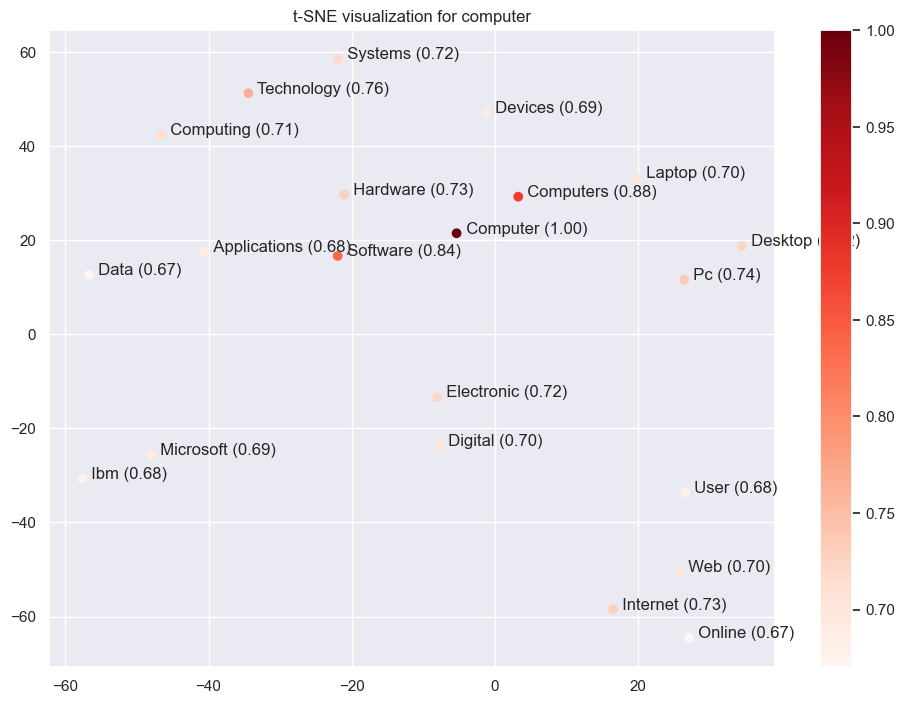

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

def tsne_scatterplot(model, search_word, topn):
    labels = [search_word]
    tokens = [model[search_word]]
    similar = [1]
    close_words = model.similar_by_word(search_word, topn=topn)
    for word in close_words:
        tokens.append(model[word[0]])
        labels.append(word[0])
        similar.append(word[1])

    tokens = np.array(tokens)

    tsne_model = TSNE(n_components=2, init='pca', perplexity=5)
    coordinates = tsne_model.fit_transform(tokens)

    df = pd.DataFrame({'x': [x for x in coordinates[:, 0]],
                       'y': [y for y in coordinates[:, 1]],
                       'words': labels,
                       'similarity': similar})

    fig, ax = plt.subplots()
    plot = ax.scatter(df.x, df.y, c=df.similarity, cmap='Reds')
    for i in range(len(df)):
        ax.annotate("  {} ({:.2f})".format(df.words[i].title(),
                                           df.similarity[i]),
                    (df.x[i], df.y[i]))

    plt.colorbar(mappable=plot, ax=ax)
    plt.title('t-SNE visualization for {}'.format(search_word))
    plt.show()

tsne_scatterplot(glove_vectors, "computer", 20)

The main problem of static embeddings is that, as the name suggests, the word representation is static and won't change after the training. Let's see an example:

In [43]:
sent1='the european central bank cuts rates to 3.5'
sent2='the rive gauche is the southern bank of the seine'

# Your code here
# convert each sentence into a list of embeddings named 'embs1' and 'embs2' respectively
embs1 = [glove_vectors[word] for word in sent1.split() if word in glove_vectors]    
embs2 = [glove_vectors[word] for word in sent2.split() if word in glove_vectors]


all(embs1[3] == embs2[6])

True

Without other solutions (e.g. a RNN that uses the embeddings as input) if we rely on static word embeddings only, the meaning of polysemic words will be somewhere between the two senses, perhaps more unbalanced towards one sense.

In [44]:
# Your code here
# Hint: try to compare it with 'treasury' and 'coast'
all(embs1[3] == glove_vectors['treasury'])
all(embs2[6] == glove_vectors['coast']) 

False

**In this case, is the embedding for 'bank' more biased toward the financial institution or ground bounding waters? Why it happens?**

*The embedding of “bank” is biased toward the financial institution meaning. This is because static embeddings give one vector per word, and since “bank” appears much more often in financial contexts in the training corpus, the financial sense dominates its representation.*

An interesting property of these models is that we can find analogies of the form “A is to B what C is to X” with basic arithmetic, for example `King`-`Man`+`Woman`~`Queen`.

We can use the [most_similar()](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) method to search for the top-n most similar words to a 'positive' list and at the same time dissimilar from 'negative'.

In [45]:
glove_vectors.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [ ]:
# Your code here
# try to write similar analogies for:
# woman - man + grandfather
# berlin - germany + france

def analogy(a, b, c, model, topn=5):
    """
    Solve analogy: a - b + c = ?
    Example: king - man + woman = queen
    """
    return model.most_similar(positive=[a, c], negative=[b], topn=topn)

print( analogy('woman', 'man', 'grandfather', glove_vectors))
print(analogy('berlin', 'germany', 'france', glove_vectors))



[('grandmother', 0.8358322978019714), ('granddaughter', 0.8109342455863953), ('mother', 0.7872799038887024), ('daughter', 0.7718198299407959), ('niece', 0.7682032585144043)]
[('paris', 0.8848407864570618), ('prohertrib', 0.7012835144996643), ('french', 0.6878857016563416), ('brussels', 0.6756916642189026), ('london', 0.6615888476371765)]


You should get `grandmother` and `paris` at the top places

This method could be usefull to explore biases in the model, hidden also in modern LLMs.

For example:

In [ ]:

print(glove_vectors.most_similar(positive=['woman', 'doctor'], negative=['man'])[0])

('nurse', 0.7735227942466736)


## +++ End of the mandatory section +++

## **Advance only**

In the first part of this notebook we trained our tf-idf model on questions only, but if you want to try to develop a more interesting ranking model you can complete the `ranking.py` script.

In this case we aim to retrieve relevant answers given the Stackoverflow's questions. Having an Id for each record in the dataset, we can indeed check if the match between question and answer is correct.
We measure the performance of the model with the Hits@k score, that is the number of correct matches in the top-k results. Analogously one can implement Precision@k and Recall@k, but is not required in this exercise.

Complete the script and do some experiments if you want, report your results at the end